In [1]:
pip install OpenEXR numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.0 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import OpenEXR
import Imath
import numpy as np
import os

def get_exr_info(exr_file):
    file = OpenEXR.InputFile(exr_file)
    header = file.header()
    
    # Get image dimensions
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    # Get the number of channels
    channels = file.header()['channels'].keys()
    num_channels = len(channels)
    
    return width, height, num_channels, channels

# Folder path to your images
image_folder = '/kaggle/input/kaist-spectral/Dataset'

# Loop through all images and check their dimensions and channels
for image_name in os.listdir(image_folder):
    if image_name.endswith('.exr'):
        image_path = os.path.join(image_folder, image_name)
        try:
            width, height, num_channels, channels = get_exr_info(image_path)
            print(f'{image_name} - Width: {width}, Height: {height}, Channels: {num_channels}')
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

scene03_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene01_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene17_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene12_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene13_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene11_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene04_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene02_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene10_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene19_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene25_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene22_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene23_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene29_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene28_reflectance.exr - Width: 3376, Height: 2704, Channels: 34
scene26_re

In [3]:
file = OpenEXR.InputFile(os.path.join(image_folder, os.listdir(image_folder)[0]))
print(file.header())

{'channels': {'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1), 'w420nm': HALF (1, 1), 'w430nm': HALF (1, 1), 'w440nm': HALF (1, 1), 'w450nm': HALF (1, 1), 'w460nm': HALF (1, 1), 'w470nm': HALF (1, 1), 'w480nm': HALF (1, 1), 'w490nm': HALF (1, 1), 'w500nm': HALF (1, 1), 'w510nm': HALF (1, 1), 'w520nm': HALF (1, 1), 'w530nm': HALF (1, 1), 'w540nm': HALF (1, 1), 'w550nm': HALF (1, 1), 'w560nm': HALF (1, 1), 'w570nm': HALF (1, 1), 'w580nm': HALF (1, 1), 'w590nm': HALF (1, 1), 'w600nm': HALF (1, 1), 'w610nm': HALF (1, 1), 'w620nm': HALF (1, 1), 'w630nm': HALF (1, 1), 'w640nm': HALF (1, 1), 'w650nm': HALF (1, 1), 'w660nm': HALF (1, 1), 'w670nm': HALF (1, 1), 'w680nm': HALF (1, 1), 'w690nm': HALF (1, 1), 'w700nm': HALF (1, 1), 'w710nm': HALF (1, 1), 'w720nm': HALF (1, 1)}, 'compression': ZIP_COMPRESSION, 'dataWindow': (0, 0) - (3375, 2703), 'displayWindow': (0, 0) - (3375, 2703), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.

In [4]:
def load_exr_to_pixel_data(exr_file):
    file = OpenEXR.InputFile(exr_file)
    header = file.header()

    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1

    #exclude RGB channels
    channels = [channel for channel in header['channels'].keys() if channel.startswith('w') and channel.endswith('nm')]
    # Extract actual wavelengths from the channel names
    wavelengths = [int(channel[1:-2]) for channel in channels]
    # Ensure they're sorted
    wavelengths = sorted(wavelengths)


    # Define the pixel type (float)
    pt = Imath.PixelType(Imath.PixelType.FLOAT)

    # Read each channel's data
    pixel_data = []
    for channel in channels:
        #convert raw pixel data into floating point numbers
        channel_data = np.frombuffer(file.channel(channel, pt), dtype=np.float32)
        channel_data = channel_data.reshape((height, width))  # Reshape into 2D
        pixel_data.append(channel_data)

    # Stack all the channel data into a (height, width, num_channels) array
    pixel_data = np.stack(pixel_data, axis=-1)

    # Flatten the image into an array of shape (height * width, num_channels)
    pixel_data = pixel_data.reshape(-1, len(wavelengths))  # Each pixel becomes a row

    return pixel_data

image_folder = '/kaggle/input/kaist-spectral/Dataset'

In [5]:
channels = [channel for channel in file.header()['channels'].keys() if channel.startswith('w') and channel.endswith('nm')]
wavelengths = [int(channel[1:-2]) for channel in channels]
wavelengths = sorted(wavelengths)

In [22]:
import random
import cv2
all_pixel_data_1 = []

# Loop through images 1-6 and extract pixel data
for image_name in os.listdir(image_folder):
    number = int(image_name[5:7])
    if 1 <= number <= 6:
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            
            #Get the average height of each pixel's spectral profile for use in thresholding
            avg_heights = np.mean(pixel_data, axis=1)
            
            #reshape image to use otsu thresholding
            image_reshaped = avg_heights.reshape(2704, 3376)
            image_normalized = cv2.normalize(image_reshaped, None, 0, 255, cv2.NORM_MINMAX)
            image_uint8 = image_normalized.astype(np.uint8)
            _, otsu_thresholded = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            #find indices of foreground (non-noisy) and background (flat/noisy) spectra
            foreground_indices = np.argwhere(otsu_thresholded == 255)
            background_indices = np.argwhere(otsu_thresholded == 0)
            
            #Need 33,333 spectra from each image, where 98% are foreground and 2% are background
            random_indices_foreground = random.sample(range(len(foreground_indices)), 32666)
            random_indices_background = random.sample(range(len(foreground_indices)), 667)
            
            #Select the pixels that correspond with the random indices from the image
            selected_indices_foreground = [(foreground_indices[idx][0], foreground_indices[idx][1]) for idx in random_indices_foreground]
            selected_foreground = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_foreground]

            selected_indices_background = [(background_indices[idx][0], background_indices[idx][1]) for idx in random_indices_background]
            selected_background = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_background]

            #Save all spectra in a list
            all_pixel_data_1.append(selected_foreground)
            all_pixel_data_1.append(selected_background)
        
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data_1 = [np.stack(sublist, axis=0) for sublist in all_pixel_data_1]
all_pixel_data_1 = np.concatenate(all_pixel_data_1, axis=0)

print(f"Shape of pixel data: {all_pixel_data_1.shape}")

Shape of pixel data: (199998, 31)


In [25]:
np.save("all_pixel_data_1.npy", all_pixel_data_1)

In [26]:
all_pixel_data_2 = []

# Loop through images 7-12 and extract pixel data
for image_name in os.listdir(image_folder):
    number = int(image_name[5:7])
    if 7 <= number <= 12:
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            
            #Get the average height of each pixel's spectral profile for use in thresholding
            avg_heights = np.mean(pixel_data, axis=1)
            
            #reshape image to use otsu thresholding
            image_reshaped = avg_heights.reshape(2704, 3376)
            image_normalized = cv2.normalize(image_reshaped, None, 0, 255, cv2.NORM_MINMAX)
            image_uint8 = image_normalized.astype(np.uint8)
            _, otsu_thresholded = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            #find indices of foreground (non-noisy) and background (flat/noisy) spectra
            foreground_indices = np.argwhere(otsu_thresholded == 255)
            background_indices = np.argwhere(otsu_thresholded == 0)
            
            #Need 33,333 spectra from each image, where 98% are foreground and 2% are background
            random_indices_foreground = random.sample(range(len(foreground_indices)), 32666)
            random_indices_background = random.sample(range(len(foreground_indices)), 667)
            
            #Select the pixels that correspond with the random indices from the image
            selected_indices_foreground = [(foreground_indices[idx][0], foreground_indices[idx][1]) for idx in random_indices_foreground]
            selected_foreground = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_foreground]

            selected_indices_background = [(background_indices[idx][0], background_indices[idx][1]) for idx in random_indices_background]
            selected_background = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_background]

            #Save all spectra in a list
            all_pixel_data_2.append(selected_foreground)
            all_pixel_data_2.append(selected_background)
        
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data_2 = [np.stack(sublist, axis=0) for sublist in all_pixel_data_2]
all_pixel_data_2 = np.concatenate(all_pixel_data_2, axis=0)

print(f"Shape of pixel data: {all_pixel_data_2.shape}")

Shape of pixel data: (199998, 31)


In [30]:
np.save("all_pixel_data_2.npy", all_pixel_data_2)

In [31]:
all_pixel_data_3 = []

# Loop through images 13-18 and extract pixel data
for image_name in os.listdir(image_folder):
    number = int(image_name[5:7])
    if 13 <= number <= 18:
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            
            #Get the average height of each pixel's spectral profile for use in thresholding
            avg_heights = np.mean(pixel_data, axis=1)
            
            #reshape image to use otsu thresholding
            image_reshaped = avg_heights.reshape(2704, 3376)
            image_normalized = cv2.normalize(image_reshaped, None, 0, 255, cv2.NORM_MINMAX)
            image_uint8 = image_normalized.astype(np.uint8)
            _, otsu_thresholded = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            #find indices of foreground (non-noisy) and background (flat/noisy) spectra
            foreground_indices = np.argwhere(otsu_thresholded == 255)
            background_indices = np.argwhere(otsu_thresholded == 0)
            
            #Need 33,333 spectra from each image, where 98% are foreground and 2% are background
            random_indices_foreground = random.sample(range(len(foreground_indices)), 32666)
            random_indices_background = random.sample(range(len(foreground_indices)), 667)
            
            #Select the pixels that correspond with the random indices from the image
            selected_indices_foreground = [(foreground_indices[idx][0], foreground_indices[idx][1]) for idx in random_indices_foreground]
            selected_foreground = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_foreground]

            selected_indices_background = [(background_indices[idx][0], background_indices[idx][1]) for idx in random_indices_background]
            selected_background = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_background]

            #Save all spectra in a list
            all_pixel_data_3.append(selected_foreground)
            all_pixel_data_3.append(selected_background)
        
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data_3 = [np.stack(sublist, axis=0) for sublist in all_pixel_data_3]
all_pixel_data_3 = np.concatenate(all_pixel_data_3, axis=0)

print(f"Shape of pixel data: {all_pixel_data_3.shape}")

Shape of pixel data: (199998, 31)


In [34]:
np.save("all_pixel_data_3.npy", all_pixel_data_3)

In [35]:
all_pixel_data_4 = []

# Loop through images 19-24 and extract pixel data
for image_name in os.listdir(image_folder):
    number = int(image_name[5:7])
    if 19 <= number <= 24:
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            
            #Get the average height of each pixel's spectral profile for use in thresholding
            avg_heights = np.mean(pixel_data, axis=1)
            
            #reshape image to use otsu thresholding
            image_reshaped = avg_heights.reshape(2704, 3376)
            image_normalized = cv2.normalize(image_reshaped, None, 0, 255, cv2.NORM_MINMAX)
            image_uint8 = image_normalized.astype(np.uint8)
            _, otsu_thresholded = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            #find indices of foreground (non-noisy) and background (flat/noisy) spectra
            foreground_indices = np.argwhere(otsu_thresholded == 255)
            background_indices = np.argwhere(otsu_thresholded == 0)
            
            #Need 33,333 spectra from each image, where 98% are foreground and 2% are background
            random_indices_foreground = random.sample(range(len(foreground_indices)), 32666)
            random_indices_background = random.sample(range(len(foreground_indices)), 667)
            
            #Select the pixels that correspond with the random indices from the image
            selected_indices_foreground = [(foreground_indices[idx][0], foreground_indices[idx][1]) for idx in random_indices_foreground]
            selected_foreground = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_foreground]

            selected_indices_background = [(background_indices[idx][0], background_indices[idx][1]) for idx in random_indices_background]
            selected_background = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_background]

            #Save all spectra in a list
            all_pixel_data_4.append(selected_foreground)
            all_pixel_data_4.append(selected_background)
        
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data_4 = [np.stack(sublist, axis=0) for sublist in all_pixel_data_4]
all_pixel_data_4 = np.concatenate(all_pixel_data_4, axis=0)

print(f"Shape of pixel data: {all_pixel_data_4.shape}")

Shape of pixel data: (199998, 31)


In [38]:
np.save("all_pixel_data_4.npy", all_pixel_data_4)

In [39]:
all_pixel_data_5 = []

# Loop through images 25-30 and extract pixel data
for image_name in os.listdir(image_folder):
    number = int(image_name[5:7])
    if 25 <= number <= 30:
        image_path = os.path.join(image_folder, image_name)
        try:
            pixel_data = load_exr_to_pixel_data(image_path)
            
            #Get the average height of each pixel's spectral profile for use in thresholding
            avg_heights = np.mean(pixel_data, axis=1)
            
            #reshape image to use otsu thresholding
            image_reshaped = avg_heights.reshape(2704, 3376)
            image_normalized = cv2.normalize(image_reshaped, None, 0, 255, cv2.NORM_MINMAX)
            image_uint8 = image_normalized.astype(np.uint8)
            _, otsu_thresholded = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            #find indices of foreground (non-noisy) and background (flat/noisy) spectra
            foreground_indices = np.argwhere(otsu_thresholded == 255)
            background_indices = np.argwhere(otsu_thresholded == 0)
            
            #Need 33,333 spectra from each image, where 98% are foreground and 2% are background
            random_indices_foreground = random.sample(range(len(foreground_indices)), 32666)
            random_indices_background = random.sample(range(len(foreground_indices)), 667)
            
            #Select the pixels that correspond with the random indices from the image
            selected_indices_foreground = [(foreground_indices[idx][0], foreground_indices[idx][1]) for idx in random_indices_foreground]
            selected_foreground = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_foreground]

            selected_indices_background = [(background_indices[idx][0], background_indices[idx][1]) for idx in random_indices_background]
            selected_background = [pixel_data.reshape(2704, 3376, 31)[row, col, :] for row, col in selected_indices_background]

            #Save all spectra in a list
            all_pixel_data_5.append(selected_foreground)
            all_pixel_data_5.append(selected_background)
        
        except Exception as e:
            print(f"Failed to process {image_name}: {e}")

# Concatenate pixel data from all images
all_pixel_data_5 = [np.stack(sublist, axis=0) for sublist in all_pixel_data_5]
all_pixel_data_5 = np.concatenate(all_pixel_data_5, axis=0)

print(f"Shape of pixel data: {all_pixel_data_5.shape}")

Shape of pixel data: (199998, 31)


In [43]:
np.save("all_pixel_data_5.npy", all_pixel_data_5)

In [44]:
all_pixel_data = np.concatenate((all_pixel_data_1, all_pixel_data_2, all_pixel_data_3, all_pixel_data_4, all_pixel_data_5), axis=0)
all_pixel_data.shape

(999990, 31)

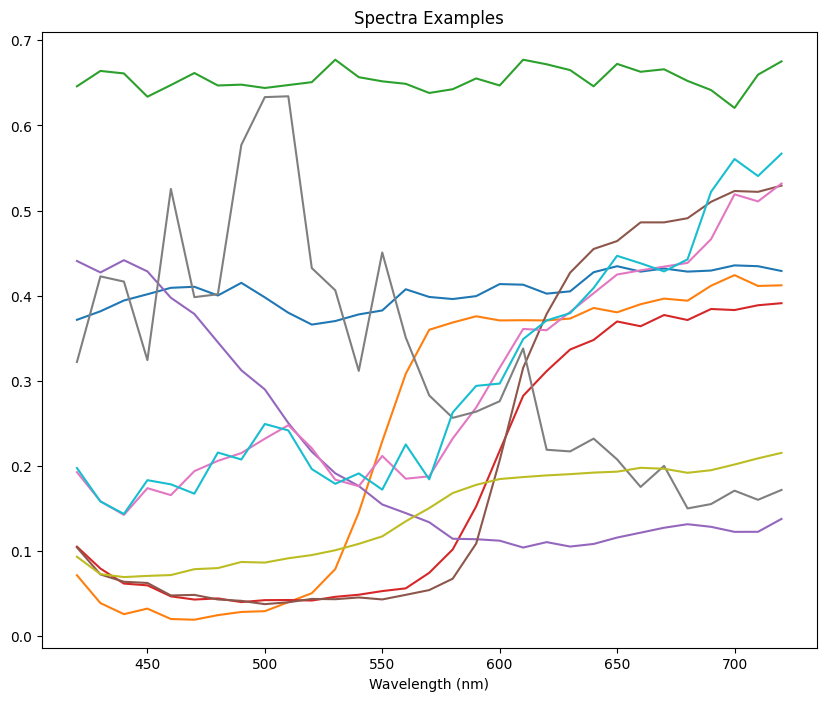

In [60]:
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for i in range(10):
    index = random.randint(1, all_pixel_data.shape[0])
    plt.plot(wavelengths, all_pixel_data[index])

plt.title("Spectra Examples")
plt.xlabel("Wavelength (nm)");

In [61]:
np.save("1mil_pixel_data.npy", all_pixel_data)